In [12]:
import re, os
import nltk
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

In [13]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [14]:
os.listdir(".")

['.ipynb_checkpoints',
 'NLP Disaster Tweets - BLSTM.ipynb',
 'NLP Disaster Tweets - Naive Bayes.ipynb',
 'test.csv',
 'train.csv']

### Note: The following steps are the exact same as those in the 'NLP Disaster Tweets - Naive Bayes,ipynb' notebook. For a more full explanation of steps, see the annotations there. 

### The details of the bidirectional LSTM model start at '1. Bidirectional LSTM with Attention'

In [15]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
print("There are {} tweets".format(len(train_data)))

There are 7613 tweets


In [17]:
print("Null values for each column (% of total amount of data):\n")
(train_data.isnull().sum() / len(train_data)) * 100

Null values for each column (% of total amount of data):



id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [18]:
#train_data = train_data.drop("location", 1) # remove loaction column
train_data = train_data.dropna(axis=0) # remove missing keyword entries

In [19]:
train_data.target.value_counts() # Sample from majority class accordingly

0    2884
1    2196
Name: target, dtype: int64

In [20]:
num_neg = train_data.target.value_counts()[0]
num_pos = train_data.target.value_counts()[1]

frac = num_pos / num_neg

neg_data = train_data[train_data.target == 0].sample(frac=frac)
pos_data = train_data[train_data.target == 1]

new_data = pd.concat([pos_data, neg_data])

#Shuffle the dataframe
new_data = new_data.sample(frac=1)

In [21]:
new_data.target.value_counts() # Balance issues fixed!

0    2196
1    2196
Name: target, dtype: int64

In [22]:
print("Total number of tweets in re-sampled dataframe: {}".format(len(new_data)))

Total number of tweets in re-sampled dataframe: 4392


In [23]:
print("Number of tweets w/ #: ", len([x for x in new_data.text.values if '#' in x])) # tweets with #
print("Number of tweets w/ @: ", len([x for x in new_data.text.values if '@' in x])) # tweets with @

Number of tweets w/ #:  1097
Number of tweets w/ @:  1235


In [24]:
# Keywords
new_data[['keyword', 'target']].keyword.value_counts()[:25]

collision                33
outbreak                 31
damage                   30
derailed                 29
buildings%20on%20fire    29
fatalities               28
wreckage                 28
earthquake               28
rainstorm                28
displaced                27
accident                 27
whirlwind                27
oil%20spill              27
flooding                 27
danger                   27
sandstorm                27
airplane%20accident      26
attacked                 26
flames                   26
evacuation               26
ablaze                   26
armageddon               26
evacuated                26
drought                  26
wounded                  26
Name: keyword, dtype: int64

In [25]:
kwords = {}
disaster_label = 1

for word in new_data.keyword.unique():
    kword = new_data[new_data.keyword == word]
    total = kword.target.value_counts().sum()
    
    try:
        frac = kword.target.value_counts()[disaster_label] / total
    except:
        frac = 0.0 # not in any disaster-related tweets  
        
    kwords[word] = frac

sorted_kwords = {k: v for k, v in sorted(kwords.items(), key=lambda item: item[1], reverse=True)}

In [26]:
# Filter dict to get all those with majority association to disasters
new_dict = dict(filter(lambda x: x[1] > 0.75, sorted_kwords.items()))

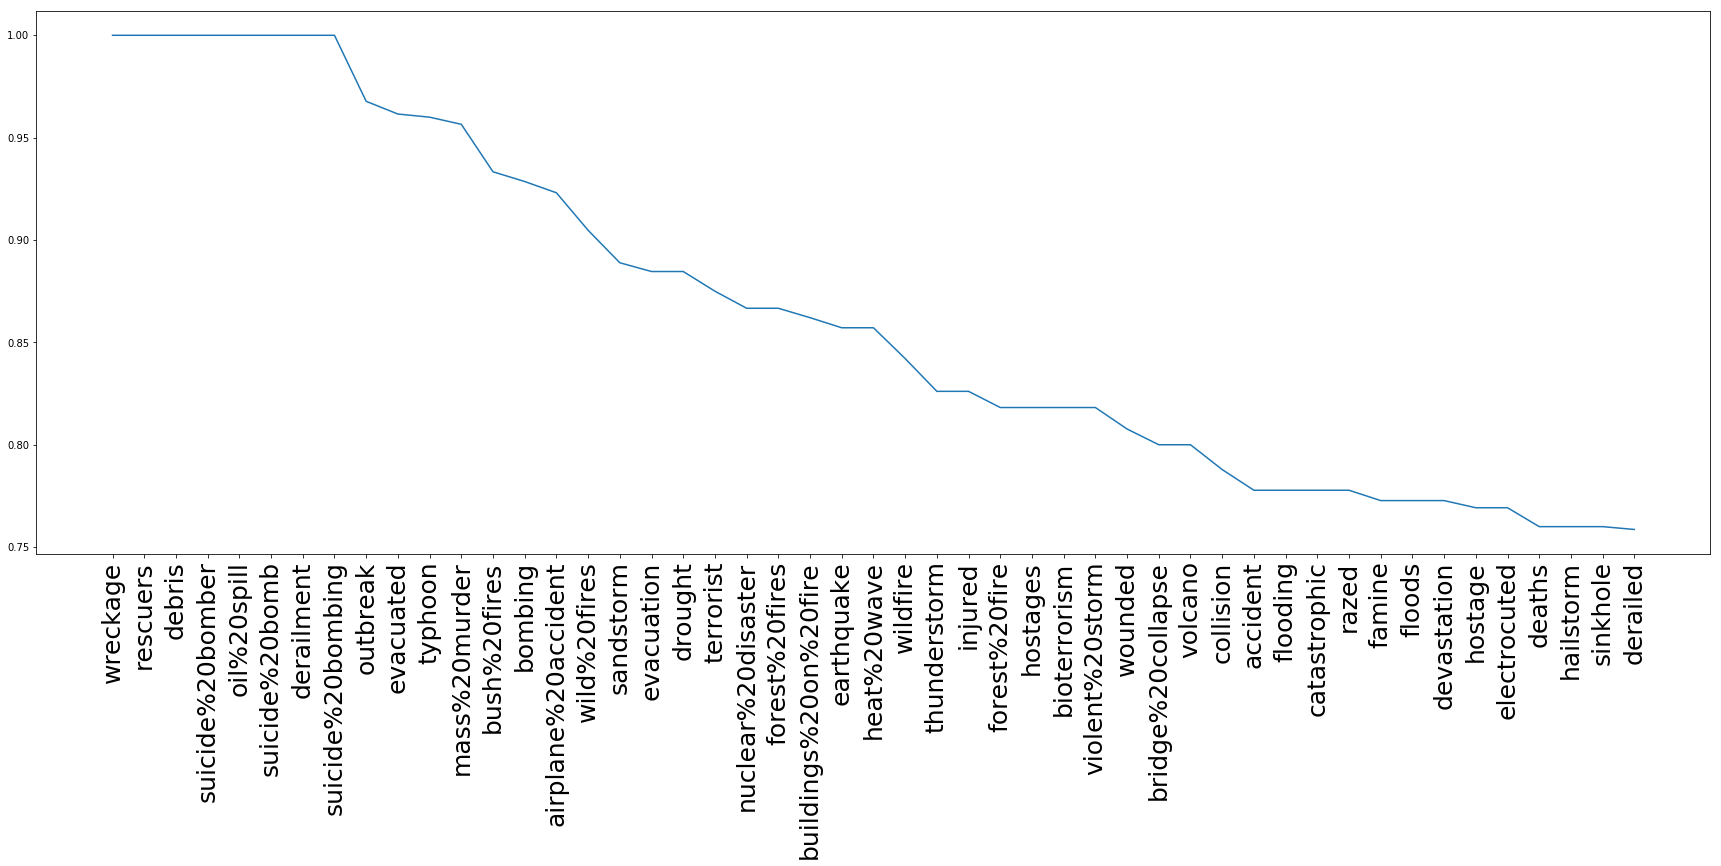

In [27]:
items = new_dict

plt.figure(figsize=(30,10))

#x = list(range(0, len(sorted_kwords.keys())))
x = list(items.keys())
y = list(items.values())

plt.xticks(rotation = 90, fontsize=25)
plt.plot(x, y)
plt.show()

In [28]:
def clean_text(text):
    
    new_text = text.lower() # lowercase the text
    new_text = re.sub(r"\w+\:\/\/([a-z]+)\.co\/\w+(\n)?", "", new_text) #remove urls
    new_text = re.sub(r"@[a-zA-Z0-9]+(?:;)*", "", new_text) # remove @s
    new_text = re.sub(r"#", "", new_text) # remove #s
    new_text = re.sub(r"[^a-z0-9A-Z]", " ", new_text) # remove non alphanumerics
    new_text = re.sub(r"[0-9]+[^\w+]", "", new_text) # remove words made wholy of digits
    new_text = re.sub(r"\b\w{1,2}\b", "", new_text) # remove words w/ 1 char
    new_text = re.sub(" +", " ", new_text) # remove multiple consecutive spaces
    
    new_text = new_text.strip() # remove leading/trailing whitespaces
    
    return new_text

In [29]:
new_data.text.values

array(['Has An Ancient Nuclear Reactor Been Discovered In Africa? \x89ÛÒ Your... http://t.co/qadUfO8zXg',
       "Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM",
       'SCREAMING @MariahCarey @ArianaGrande http://t.co/xxZD1nmb1i', ...,
       "So the IFAK is an 'individual first aid kit' to treat a single trauma victim I think I should create the EFAK or evacuation first aid kit",
       'Sex Workers Say Credit Card Bans On Online Ads Do More Harm Than Good http://t.co/B9Zx2xZ6aW',
       'The year is 2065 and the national society of meme preservation has opened the first museum where memes and their origins are displaced'],
      dtype=object)

In [30]:
#Test cleaning on given tweet
i = 6
for tweet in new_data.text.values[i:]:
    print("Original: ", tweet)
    tweet = clean_text(tweet)
    print("Cleaned: ", tweet)
    break

Original:  its only getting colder and colder and faster and faster and when i first realized it it was like a natural disaster
Cleaned:  its only getting colder and colder and faster and faster and when first realized was like natural disaster


In [31]:
tweets = {}
for i, tweet in enumerate(new_data.text):
    tweets[i] = clean_text(tweet)
    
labels = {}
for i, label in enumerate(new_data.target):
    labels[i] = label

In [32]:
import random

for i in range(len(tweets)):
    temp, label = tweets[i], labels[i]
    j = random.randint(0, len(temp.split())-1)
    word = temp.split()[j]
    temp = temp.replace(word, "")
    temp = re.sub(" +", " ", temp) # remove multiple consecutive spaces
    temp = temp.strip() # remove leading/trailing whitespaces

    tweets[len(tweets)] = temp
    labels[len(labels)] = label

In [33]:
#Takes a second...

lm = nltk.stem.WordNetLemmatizer()
all_tokens = [item for _, value in tweets.items() for item in word_tokenize(value)]
#all_tokens_lm = [lm.lemmatize(t) for t in all_tokens]
all_tokens_lm = [lm.lemmatize(t) for t in all_tokens if t not in stopwords.words('english')]

In [34]:
N = len(all_tokens_lm)
V = len(set(all_tokens_lm))
         
print(f"There are {N} tokens after processing")
print(f"There are {V} unique tokens after processing")

There are 72071 tokens after processing
There are 9343 unique tokens after processing


In [38]:
#60-20-20 train-dev-test split
cutoff = int(0.8*len(tweets))
train_cutoff = int(0.6*len(tweets))

train_set = dict(list(tweets.items())[:train_cutoff])
train_labels = dict(list(labels.items())[:train_cutoff])

validation_set = dict(list(tweets.items())[train_cutoff:cutoff])
validation_labels = dict(list(labels.items())[train_cutoff:cutoff])

test_set = dict(list(tweets.items())[cutoff:])
test_labels = dict(list(labels.items())[cutoff:])

------------

# Bidirectional LSTM w/ Attention

------------

In short, the bidirectional long-short term memory (LSTM) - abbreviated BiLSTM herein - is a variant of the recurrent neural network that, in the context of sentiment analysis, 

 - Better preserves *long-range dependencies* between words
 - Considers the dependencies of a word on both *future* and *past* words (hence, operates in a bidirectional fashion)

At a high-level, the attention layer aims to assign an "importance" factor to each word in the sequential input, helping the predictions of the network by guiding it as to how relevant each word in the input is to the prediction at the current time step. The mechanism by which the attention layer works is built by individually weighting the activation vectors at each timestep and combining them all to produce a single vector, which is further transformed to yield a final prediction vector (probablity of either diaster or non-disaster). 

For a more in-depth discussion into how a BiLSTM operates at a lower-level, please refer to the article [here](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence.). In addition, a helpful dissection of the original attention paper is available in [this](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) article.

Now that the BiLSTM model has been introduced, let us get into the nitty-gritty implementation. The following code cells will cover

- Data preparation (ie. preparing input for the neural net)
- Construction of the attention layer,
- Running the model,
- Final evaluation of the model of our test data. 

Firstly, import all the appropriate libraries

In [36]:
import random
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, MaxPooling1D, SpatialDropout1D, Conv1D
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

-----

# 1. Data preparation

----

Our BiLSTM requires certain feature vectors as input. These vectors all need have the same length, so this first step gets what the maximum tweet length is in our corpus and uses this value as our max length

In [37]:
max_seq_len = 0
for val in list(train_set.values()):
    length = len(val.split())
    max_seq_len = max(max_seq_len, length)
print("Maximum tweet length: {}".format(max_seq_len))

Maximum tweet length: 24


Next, we need to prepare out vectorizer object. This is adapted to our training corpus and is used to create our tweet vectors (note: not word vectors yet). 

The tweet vectors themselves simply consist of all the indices of their words as they appear in the vocabulary dictionary. That is, the sentence "a dog just ran by" has an associated word vector that looks something like "[0, 1789, 3456, 234]", where each number represents the index for that word in our word vocabulary. 

Since our maximum vector length is 24 and all our vectors need to be of that length, tweets which aren't as long as 24 words are padded with zeros until a length of 24 is reached

In [39]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Vectorize only the top 5000 tokens of the training data, then fetch vocab.
vectorizer = TextVectorization(max_tokens=5000, output_sequence_length=max_seq_len, standardize=None)
vectorizer.adapt(list(train_set.values()) + list(validation_set.values()))

vocab = vectorizer.get_vocabulary()

Now, we vectorize the tweets in both the training and validation sets

In [40]:
X_train = vectorizer(np.array([[s] for s in list(train_set.values())])).numpy()
y_train = np.array(list(train_labels.values()))

X_valid = vectorizer(np.array([[s] for s in list(validation_set.values())])).numpy()
y_valid = np.array(list(validation_labels.values()))

print(f"Shape of training data: {X_train.shape}")
print(f"Shape of validation data: {X_valid.shape}")

Shape of training data: (5270, 24)
Shape of validation data: (1757, 24)


In [43]:
X_train[0]

array([  31, 1034,   69,  447,   39, 3060, 1278,   18,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int64)

As you can see above, the first tweet in the training set has been padded after the 8th character with zeros

Now, we move on to create our *word* vectors. The word vectors are created using an embedding matrix, which in our case consists of rows of 100-d vectors. 

These 100-d vectors are infact learned weight vectors, the origin of which is irrelevant for now. The point is that these weight vectors are associated which each word in our vocabulary, and convey information regarding the word's "similarity" other words. These word vectors are dense representations, and serve as good inputs to the neural net (unlike, say, one-hot encodings of our words which suffer from sparseness)

The following code cell defines the `build_embedding_matrix` function, which does exactly what you think it would do: build the embedding matrix!

In [45]:
fname = "glove.6B.100d.txt"
def build_embedding_matrix(fname, vocab, embedding_dim=100):
    
    #First two elems of matrix are for padding, <UNK> tokens
    matrix, embedding_map = np.zeros((len(vocab)+2, embedding_dim)), {}
    with open(fname, "r", encoding='utf8') as f:
        for line in f.readlines():
            
            elems = line.split()
            #First element is word, rest are vector entries
            token = elems[0]
            vec = np.array([float(x) for x in elems[1:]])
            #Get the index of the word in our word tokens list
            #Then place the vector at position given by index
            embedding_map[token] = vec
    
    suc, fail = 0, 0
    wordmap = dict(zip(vocab, range(len(vocab))))
    for word, i in wordmap.items():
        #Only words in vocab that have embedding can be used
        vec = embedding_map.get(word)
        if vec is not None:
            matrix[i] = vec
            suc += 1
        else:
            fail += 1
    
    print(f"Number of words successfully embedded: {suc}, Unsuccessful attempts: {fail}")
    return matrix

Now, create the matrix

In [46]:
#Takes a second...
embedding_matrix = build_embedding_matrix(fname, vocab)

Number of words successfully embedded: 4666, Unsuccessful attempts: 334


In [47]:
print(f"Shape of the embedding matrix: {embedding_matrix.shape}")

Shape of the embedding matrix: (5002, 100)


Now that the matrix is created, we can use it to define an `Embedding` layer for our neural network

In [50]:
num_tokens = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = X_train.shape[1]

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable=False,
    input_length = max_seq_len
)

----

# 2. Create the attention layer

----

This deserves some attention (hah). As mentioned previously, the idea behind attention is to perform a linear combination of a bunch of activation vectors. This is done in the call function. The linear combination is passed throuh a hyperbolic tangent non-linearity followed by a softmax layer to yield a probability vector.

In [55]:
class Attention(keras.layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences=return_sequences
        super(Attention, self).__init__()
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({'return_sequences': self.return_sequences})
        return config
    
    def build(self, input_shape):
        ##last index of the input_shape is the number of dimensions of the prev
        ##RNN layer. last but 1 index is the num of timesteps
        self.w=self.add_weight(shape=(input_shape[-1], 1), initializer="normal", name='weight')
        self.b=self.add_weight(shape=(input_shape[1], 1), initializer="zeros", name='bias')
        
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        ##x is the input tensor..each word that needs to be attended to
        ##Below is the main processing done during training
        ##K is the Keras Backend import
        e = K.tanh(K.dot(x,self.w)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        

        return K.sum(output, axis=1)

----

# 3. Creating/running the model

----

Below, we create our BiLSTM and run it on the training and validation data.

As we can see below, the model consists of:

- The embedding layer (to vectorize our words)
- A spatial dropout layer (with p = 0.50)
- The BiLSTM layer (with dropout p = 0.20 and a recurrent dropout p = 0.20
- A standard dropout layer (p = 0.50 again)
- The Attention layer
- A final dense (fully-connected) layer with a sigmoid activation function (since we doing binary classification)

In [57]:
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.50))
model.add(Bidirectional(LSTM(max_seq_len, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Attention(return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 100)           500200    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 24, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24, 48)            24000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
attention_2 (Attention)      (None, 48)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 49        
Total params: 524,321
Trainable params: 24,121
Non-trainable params: 500,200
___________________________________________

Set out model hyperparameters

In [59]:
batch_size = 128
epochs = 100
lr = 0.001

Allow early stopping if the model validation loss stagnates for a certain time

In [60]:
#Enable early stopping if the validation loss hasn't been decreasing for 20 epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

Finally, train the model!

In [61]:
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                     callbacks=[es], validation_data=(X_valid, y_valid))

Epoch 1/100
42/42 [==============================] - 2s 39ms/step - loss: 0.6707 - accuracy: 0.6078 - val_loss: 0.6012 - val_accuracy: 0.7382
Epoch 2/100
42/42 [==============================] - 1s 28ms/step - loss: 0.5804 - accuracy: 0.7127 - val_loss: 0.4968 - val_accuracy: 0.7672
Epoch 3/100
42/42 [==============================] - 1s 27ms/step - loss: 0.5296 - accuracy: 0.7395 - val_loss: 0.4829 - val_accuracy: 0.7695
Epoch 4/100
42/42 [==============================] - 1s 27ms/step - loss: 0.5198 - accuracy: 0.7454 - val_loss: 0.4745 - val_accuracy: 0.7832
Epoch 5/100
42/42 [==============================] - 1s 27ms/step - loss: 0.5127 - accuracy: 0.7499 - val_loss: 0.4681 - val_accuracy: 0.7792
Epoch 6/100
42/42 [==============================] - 1s 27ms/step - loss: 0.5046 - accuracy: 0.7474 - val_loss: 0.4602 - val_accuracy: 0.7871
Epoch 7/100
42/42 [==============================] - 1s 26ms/step - loss: 0.5067 - accuracy: 0.7474 - val_loss: 0.4707 - val_accuracy: 0.7752
Epoch 

42/42 [==============================] - 1s 26ms/step - loss: 0.4061 - accuracy: 0.8161 - val_loss: 0.3817 - val_accuracy: 0.8344
Epoch 59/100
42/42 [==============================] - 1s 26ms/step - loss: 0.4002 - accuracy: 0.8146 - val_loss: 0.3765 - val_accuracy: 0.8327
Epoch 60/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4103 - accuracy: 0.8133 - val_loss: 0.3778 - val_accuracy: 0.8384
Epoch 61/100
42/42 [==============================] - 1s 26ms/step - loss: 0.3945 - accuracy: 0.8205 - val_loss: 0.3858 - val_accuracy: 0.8349
Epoch 62/100
42/42 [==============================] - 1s 26ms/step - loss: 0.4020 - accuracy: 0.8156 - val_loss: 0.3832 - val_accuracy: 0.8349
Epoch 63/100
42/42 [==============================] - 1s 26ms/step - loss: 0.4013 - accuracy: 0.8137 - val_loss: 0.3729 - val_accuracy: 0.8327
Epoch 64/100
42/42 [==============================] - 1s 26ms/step - loss: 0.4034 - accuracy: 0.8184 - val_loss: 0.3733 - val_accuracy: 0.8338
Epoch 65/100

The model has been trained, so now we naturally should view the learning curves to assess how our model has performed, and potentially spot any under/overfitting issues

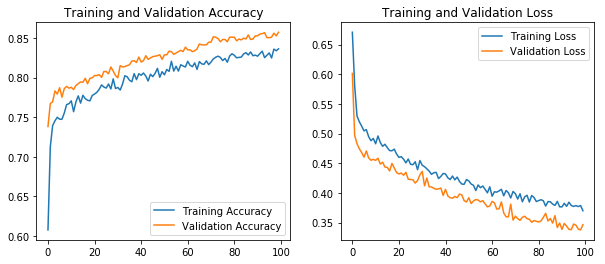

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

----

# 4. Evaluate on the test set

---

With our trained model, we are ready to evaluate its ability on the unseen test data. Below, we prepare the testing data following the data preparation steps we used before, and perform one-time inference to get the final F1 score for our model

In [63]:
test = vectorizer(np.array([[s] for s in list(test_set.values())])).numpy()
test = pad_sequences(test, maxlen=X_train.shape[1])

In [64]:
predictions = model.predict(test)
predictions[predictions > 0.5] = 1
predictions[predictions < 0.5] = 0

In [65]:
score_lstm = f1_score(list(test_labels.values()), predictions)
print("BiLSTM F1 score: {}".format(score_lstm))

BiLSTM F1 score: 0.8220392653578213
